In [1]:
import torch
from torch.utils.data import Dataset
from pycocotools.coco import COCO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from util import gaussian_heatmap, visualize_dataset_sample

In [2]:
ANNOTATION_PATH = "./dataset/annotation/aligned_gauge_keypoints.json"
IMAGE_PATH = "./dataset/image"

In [3]:
class GaugeDataset(Dataset):
    def __init__(self, annotation_path, image_path, transform=None, sigma=2):
        self.coco = COCO(annotation_path)
        self.ids = list(self.coco.imgs.keys())

        all_ids = list(self.coco.imgs.keys())
        self.ids = []
        for img_id in all_ids:
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            if len(ann_ids) > 0:
                self.ids.append(img_id)
        
        self.image_path = image_path
        self.transform = transform
        self.input_size = 640   # 입력 이미지 크기
        self.output_size = 160  # 모델 출력 크기 1/4
        self.sigma = sigma      # 가우시안 반경

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]

        img_info = self.coco.loadImgs(img_id)[0]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)

        anns = self.coco.loadAnns(ann_ids)[0]

        img_path = os.path.join(self.image_path, img_info["file_name"])
        image = cv2.imread(img_path)

        if image is None:
            raise FileNotFoundError(f"Image file not found: {img_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        kp = np.array(anns["keypoints"]).reshape(-1, 3)

        heatmaps = gaussian_heatmap(
            keypoints=kp[:, :2],
            input_size=self.input_size,
            output_size=self.output_size,
            sigma=self.sigma
            )

        if self.transform:
            image = self.transform(image)

        return image, heatmaps

In [4]:
dataset = GaugeDataset(annotation_path=ANNOTATION_PATH, image_path=IMAGE_PATH)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


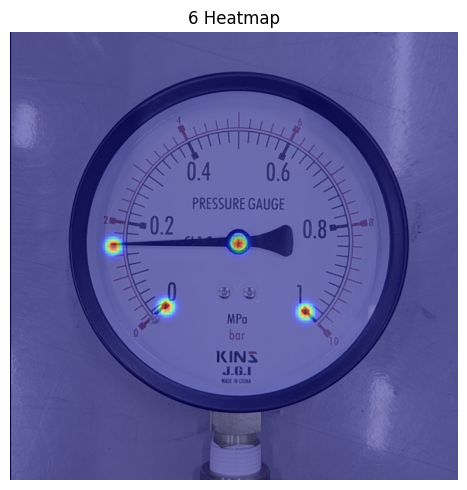

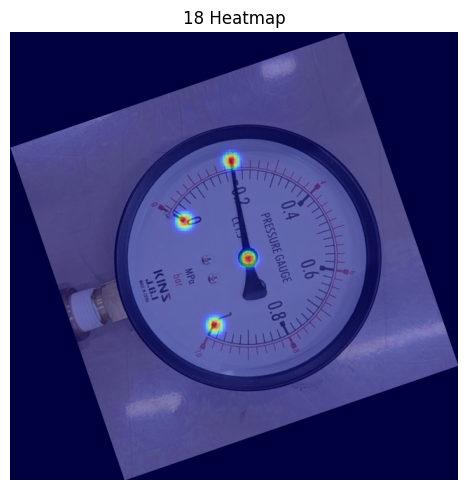

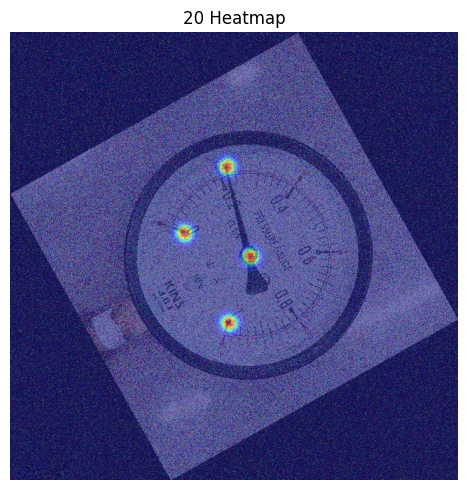

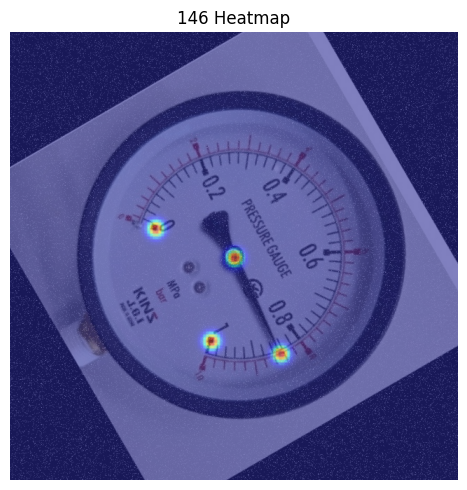

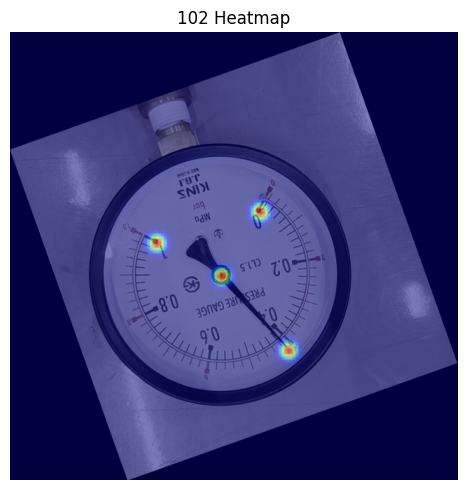

In [11]:
from random import sample

dataset_size = len(dataset)
random_sample = sample(range(dataset_size), 5)

for i in random_sample:
    visualize_dataset_sample(dataset, index=i)